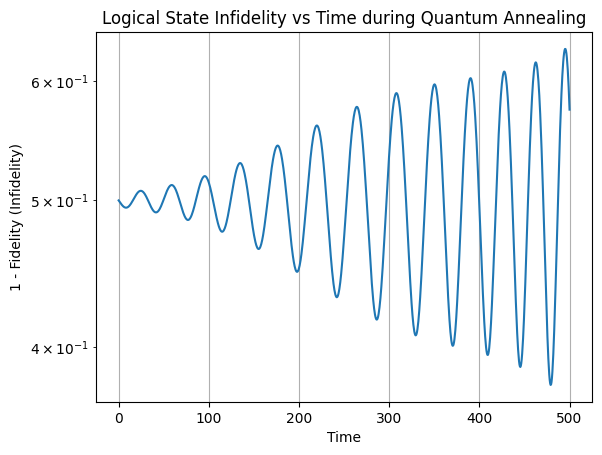

In [24]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma_m = 1.0
Omega_0 = 0.1 * gamma_m
tau = 2.5 / gamma_m
eta = 1.0
gamma = 1.25e-3 * gamma_m
top = 500 / gamma_m
theta1 = -0.54
theta2 = 0.8
tau_m = 1 / (2 * gamma_m * eta)

# Logical operators
X = sigmax()
Z = sigmaz()
I = qeye(2)

# Time-dependent coefficients
def a(t): return 1 - t / top
def b(t): return t / top

# Hamiltonians
def hL(t):
    return -Omega_0 * (a(t) * X + b(t) * Z)

def h_spurious(t):
    return -Omega_0 * (a(t) * X + b(t) * Z / 3)

# Vq operator
def Vq(t):
    t_det = tau * np.log(2 / (1 + theta1))
    UL = (-1j * hL(t) * t_det).expm()
    US = (-1j * h_spurious(t) * t_det).expm()
    return UL * US.dag()

# Misdiagnosis probability
def p_misdiag_X2(tau, theta1, theta2, tau_m):
    delta = theta2 - theta1
    c = 1.607
    return c * np.exp(-delta**2 * tau / (2 * tau_m)) / (delta * np.sqrt(tau / tau_m))

p_mis_X2 = p_misdiag_X2(tau, theta1, theta2, tau_m)

# Logical error rate
delta_t12 = delta_t23 = tau * np.log(2 / (1 + theta1))
delta_t13 = tau * np.log((1 + theta2) / (1 + theta1))
Gamma_L = gamma * p_mis_X2 + 2 * gamma**2 * (delta_t12 + delta_t23 + delta_t13)

# Initial state |0>
psi0 = basis(2, 0)
rho0 = ket2dm(psi0)

# Time list
timesteps = 1000
tlist = np.linspace(0, top, timesteps)
dt = tlist[1] - tlist[0]
rho = rho0
rho_t = [rho]

# Evolve density matrix step-by-step
for t in tlist[1:]:
    HL = hL(t)
    V = Vq(t)
    drho = (
        -1j * (HL * rho - rho * HL)
        + Gamma_L * (X * rho * X - rho)
        + gamma * (1 - p_mis_X2) * (V * rho * V.dag() - rho)
    )
    rho = rho + dt * drho
    rho_t.append(rho)

# Fidelity calculation
fidelities = []
for i, t in enumerate(tlist):
    theta = np.arctan2(a(t), b(t))
    psi_target = (np.cos(theta / 2) * basis(2, 0) + np.sin(theta / 2) * basis(2, 1)).unit()
    fidelities.append(expect(ket2dm(psi_target), rho_t[i]))

# Plot logical state infidelity: 1 - F(t)
infidelities = [1 - f for f in fidelities]

plt.plot(tlist, infidelities)
plt.xlabel('Time')
plt.ylabel('1 - Fidelity (Infidelity)')
plt.title('Logical State Infidelity vs Time during Quantum Annealing')
plt.yscale('log')  # Optional: Use log scale to highlight small errors
plt.grid(True)
plt.show()


In [25]:
X1 = tensor(X, I, I)
X2 = tensor(I, X, I)
X3 = tensor(I, I, X)

S1 = tensor(Z, Z, I)
S2 = tensor(I, Z, Z)

X_L = tensor(X, X, X)
Z_L = (tensor(Z, I, I) + tensor(I, Z, I) + tensor(I, I, Z)) / 3

# Bit-flip error collapse operators
c_ops = [
    np.sqrt(gamma) * X1,
    np.sqrt(gamma) * X2,
    np.sqrt(gamma) * X3
]

m_ops = [np.sqrt(gamma_m) * S1, np.sqrt(gamma_m) * S2]

# |0_L⟩ = |000⟩, |1_L⟩ = |111⟩
zero_L = basis(2, 0)
psi0 = tensor(zero_L, zero_L, zero_L)
rho0 = ket2dm(psi0)

timesteps = 1000
tlist = np.linspace(0, top, timesteps)

# Hamiltonian list for time dependence
H_t = [[X_L, lambda t, args: -Omega_0 * a(t)],
       [Z_L, lambda t, args: -Omega_0 * b(t)]]

result = smesolve(H_t, rho0, tlist, c_ops, m_ops, 
                  options={'store_states': True,
                           'store_measurement': True})

# Code subspace: spanned by |000⟩ and |111⟩
zero = tensor(basis(2,0), basis(2,0), basis(2,0))
one  = tensor(basis(2,1), basis(2,1), basis(2,1))
P_code = [zero, one]

fidelities = []

for i, rho in enumerate(result.states):
    # Project full rho onto code space
    rho_L = Qobj([[expect(zero.dag() * rho * zero), expect(zero.dag() * rho * one)],
                  [expect(one.dag()  * rho * zero), expect(one.dag()  * rho * one)]])
    
    # Target state: |ψ_L(t)⟩ = cos(θ/2)|0⟩ + sin(θ/2)|1⟩
    t = tlist[i]
    theta = np.arctan2(a(t), b(t))
    psi_target = (np.cos(theta/2) * basis(2,0) + np.sin(theta/2) * basis(2,1)).unit()
    fidelities.append(expect(ket2dm(psi_target), rho_L))

infidelities = [1 - f for f in fidelities]

plt.plot(tlist, infidelities, label='Full SME simulation')
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('1 - Fidelity')
plt.title('Logical Infidelity via SME (Full 3-Qubit Model)')
plt.grid(True)
plt.legend()
plt.show()


/Users/chenscheim/PycharmProjects/QEC_A/myenv/lib/python3.12/site-packages/qutip/solver/solver_base.py:553: FutureWarning: The "store_measurement" parameter is now an options:
Use `options={"store_measurement": False / True}`
  warnings.warn(


10.0%. Run time: 654.34s. Est. time left: 00:01:38:09
20.0%. Run time: 1351.82s. Est. time left: 00:01:30:07
30.0%. Run time: 2084.17s. Est. time left: 00:01:21:03
40.0%. Run time: 2737.08s. Est. time left: 00:01:08:25
50.0%. Run time: 3386.67s. Est. time left: 00:00:56:26
60.0%. Run time: 4037.26s. Est. time left: 00:00:44:51
70.0%. Run time: 4690.28s. Est. time left: 00:00:33:30
80.0%. Run time: 5340.92s. Est. time left: 00:00:22:15
90.0%. Run time: 5987.07s. Est. time left: 00:00:11:05
100.0%. Run time: 6634.98s. Est. time left: 00:00:00:00
Total run time: 6647.93s


TypeError: expect() missing 1 required positional argument: 'state'